# Parsing Squares

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import jupyter_compare_view
from PIL import Image

Jupyter compare_view v0.2.4


In [2]:
# https://stackoverflow.com/questions/7099290/how-to-ignore-hidden-files-using-os-listdir
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [3]:
# Feel free to edit as you like depending on where you put the files
BASE_IMAGE_DIR = "VIS_IR_DATASET"
SAVE_DIR = "ALIGNED_DATASET"

os.makedirs(SAVE_DIR, exist_ok=True)

Only need to run the following code segment if they uv and vis split has not already been done

In [4]:
fileNames = listdir_nohidden(BASE_IMAGE_DIR)
filePairs = []
for fileName in fileNames:
    # For simplicity only keep the file name, not extension
    file = fileName.split('.')[0]
    
    # Skip if already processed
    if os.path.exists(f"{SAVE_DIR}/{file}_ir.jpg") and os.path.exists(f"{SAVE_DIR}/{file}_vis.jpg"):
        continue
        
    im = cv2.imread(f"{BASE_IMAGE_DIR}/{fileName}")
    
    # Rescale
    rescale_percent = 0.5
    width = int(im.shape[1] * rescale_percent)
    height = int(im.shape[0] * rescale_percent)
    dim = (width, height)
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    
    # Split the side by side image into two halfs
    im_ir = im[:, (im.shape[1]//2):, :]
    im_vis = im[:, :(im.shape[1]//2), :]
    
    cv2.imwrite(f"{SAVE_DIR}/{file}_ir.jpg", im_ir)
    cv2.imwrite(f"{SAVE_DIR}/{file}_vis.jpg", im_vis)
    
    filePairs.append([f"{file}_ir.jpg", f"{file}_vis.jpg"]) # Subject, Template

# After done writing the individual images, write pairs.txt for SuperGlue
with open(f"{SAVE_DIR}/pairs.txt", "w") as f:
    if filePairs:
        for [vis, ir] in filePairs:
            f.write(f"{vis} {ir}\n")

# Run the SuperGlue match finder

Run a command like this in the terminal: 

```./SuperGluePretrainedNetwork/match_pairs.py --resize 1640 1232 --superglue outdoor --max_keypoints 2048 --nms_radius 3  --resize_float --input_dir ALIGNED_DATASET --input_pairs ALIGNED_DATASET/pairs.txt  --output_dir ALIGNED_DATASET/superglue --viz```

# Using the SuperGlue output to align images

In [5]:
def combine_vis_ir(im_vis, im_ir, H, w, h, save_dir, file_name):
    im_aligned = cv2.warpPerspective(im_ir, H, (w, h))
    im_aligned_grey = cv2.cvtColor(im_aligned, cv2.COLOR_BGR2GRAY).reshape((im_vis.shape[0], im_vis.shape[1], 1))
    im_combined = np.concatenate((im_vis, im_aligned_grey), axis=2)
    os.makedirs(save_dir, exist_ok=True)
    np.save(f"{save_dir}/{file_name}", im_combined)

In [8]:
def valid_space(im_warp, i, j, s):
    warp_slice = im_warp[i:i+s,j:j+s,:]
    return np.all(warp_slice == [1, 1, 1]) 

def get_patches(im_vis, im_ir, H, w, h, save_path, count, ons_dim, shift_size, is_npy=False):
    # Get a np array with ones everywhere that all channels exist in the post warped image
    warp_shape = np.ones(im_ir.shape)
    im_warp = cv2.warpPerspective(warp_shape, H, (w, h))
    
    # Align the images
    im_aligned = cv2.warpPerspective(im_ir, H, (w, h))
    im_aligned_grey = cv2.cvtColor(im_aligned, cv2.COLOR_BGR2GRAY).reshape((im_vis.shape[0], im_vis.shape[1], 1))
    os.makedirs(save_path, exist_ok=True)
    
    # Iterate through each patch and see if we can write it as a patch
    s = ons_dim + shift_size
    im_combined = np.concatenate((im_vis, im_aligned_grey), axis=2)
    
    for i in range(0, h - s, s):
        if i+s > h:
            continue
        for j in range(0, w - s, s):
            if j+s > w:
                continue
            if valid_space(im_warp, i, j, s) and i+s <= h and j+s <= w:
                # assert not os.path.exists(f"{save_path}/{count}.npy"), "[get_patches] File already exists."
                im_patch = im_combined[i:i+s, j:j+s, :]
                assert im_patch.shape == (s, s, 4), f"[get_patches] Incorrect shape {im_patch.shape}."

                # Depending on whether we want to save npy or png
                if is_npy:
                    np.save(f"{save_path}/{count}.npy", im_patch)
                else:
                    img = Image.fromarray(im_patch)
                    img.save(f"{save_path}/{count}.png")
                count += 1
    return count

In [9]:
fileNames = listdir_nohidden(BASE_IMAGE_DIR)
excludeList = ["2021-11-15_22-59-29", "2021-11-15_22-59-51", "2021-11-15_22-59-54", "2021-11-15_22-56-31"]
filePairs = []
ONS_DIM = 128
SHIFT_SIZE = 25
count = 0

for fileName in fileNames:
    fileName = fileName.split(".")[0]
    
    if fileName in excludeList:
        continue
    
    im_vis = cv2.imread(f"{SAVE_DIR}/{fileName}_vis.jpg")
    im_ir = cv2.imread(f"{SAVE_DIR}/{fileName}_ir.jpg")
    
    npz = np.load(f"{SAVE_DIR}/superglue/{fileName}_ir_{fileName}_vis_matches.npz")
    
    best_idx = npz['match_confidence'] > 0.85
    best_kpt0 = npz['keypoints0'][best_idx]
    best_kpt1 = []
    for i, idx in enumerate(best_idx):
        if idx:
            assert npz['matches'][i] != -1, "Index was not found in match"
            best_kpt1.append(npz['keypoints1'][npz['matches'][i]])
    best_kpt1 = np.array(best_kpt1)
    
    assert best_kpt0.shape == best_kpt1.shape, \
        f"File: {fileName} failed, shape {best_kpt0.shape} is different from shape {best_kpt1.shape}"
    
    assert best_kpt0.shape[0] >= 4, \
        f"File: {fileName} failed, does not have at least 4 points. It has {best_kpt0.shape[0]} instead."
    
    (H, mask) = cv2.findHomography(best_kpt0, best_kpt1, method=cv2.RANSAC)
    (h, w) = im_vis.shape[:2]
    
    # Use this function to write a stacked version
    # combine_vis_ir(im_vis, im_ir, H, w, h, f"{SAVE_DIR}/stacked/", f"{fileName}_combined.npy")
    
    # Use this function to write patches of size ONS_DIM + SHIFT_SIZE
    count = get_patches(im_vis, im_ir, H, w, h, f"{SAVE_DIR}/patches_rgbir/", count, ONS_DIM, SHIFT_SIZE)
    
print("Done")

Done



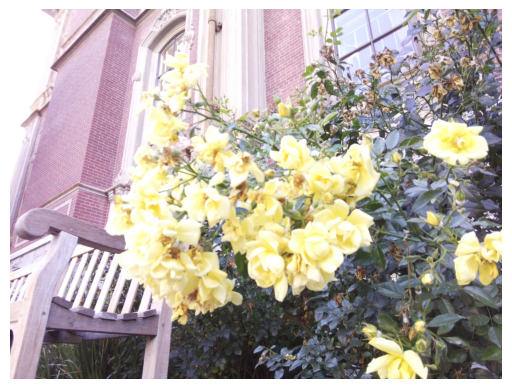
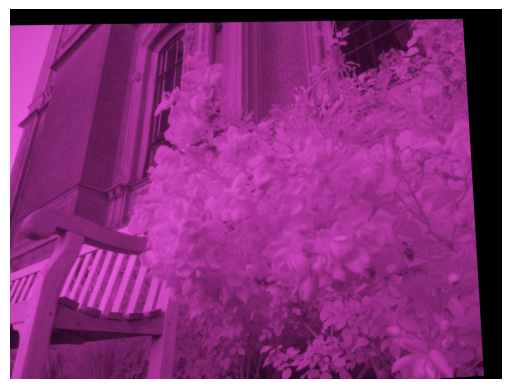

In [10]:
%%compare
fig, ax1 = plt.subplots()
ax1.axis("off")
ax1.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))

# Align and convert the 
fig, ax2 = plt.subplots()
ax2.axis("off")
aligned = cv2.warpPerspective(im_ir, H, (w, h))
ax2.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))

In [23]:
def load_and_visualize_npy(file_path):
    extension = file_path.split('.')[1]
    if extension == 'npy':
        im = np.load(file_path)
    elif extension == 'png':
        im = np.array(Image.open(file_path))
    else:
        assert False, f"Tried to open an unknown file type: {file_path}"
    im_vis = im[:, :, :3]
    im_ir = im[:, :, 3:]
    print(im_vis.shape)
    print(im_ir.shape)
    
    fig, ax1 = plt.subplots()
    ax1.axis("off")
#     ax1.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))
    ax1.imshow(im_vis)

    # Align and convert the 
    fig, ax2 = plt.subplots()
    ax2.axis("off")
    ax2.imshow(cv2.cvtColor(im_ir, cv2.COLOR_BGR2RGB))

(153, 153, 3)
(153, 153, 1)



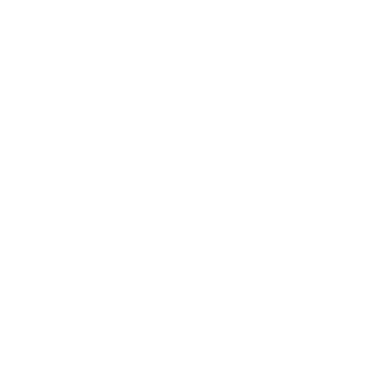
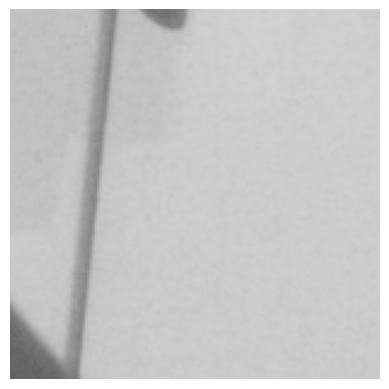

In [24]:
%%compare
file_path = f"{SAVE_DIR}/patches_rgbir/0.png"
load_and_visualize_npy(file_path)